# Image Classification Using CNN


we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications import VGG16

from PIL import Image

import os
from glob import glob
import cv2
import tensorflow as tf
import keras
from google.colab import drive

In [ ]:
#Mounting the drive
drive.mount('/content/drive')
#Setting kaggle configuration directory
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ColabNotebooks"
%cd /content/drive/MyDrive/ColabNotebooks
#Downloading and unzip dataset
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip \*.zip && rm *.zip

In [6]:
train_path = '/content/drive/MyDrive/ColabNotebooks/seg_train/seg_train/'
test_path = '/content/drive/MyDrive/ColabNotebooks/seg_test/seg_test/'
pred_path = '/content/drive/MyDrive/ColabNotebooks/seg_pred/seg_pred/'


# Open Folders

now let's first check the folders to have a look to its content.

In [7]:
for folder in  os.listdir(train_path) :
    files = glob(pathname= str( train_path + folder + '/*.jpg'))
    print(f'Found {len(files)} in folder {folder}')

Found 2191 in folder buildings
Found 2271 in folder forest
Found 2404 in folder glacier
Found 2512 in folder mountain
Found 2274 in folder sea
Found 2382 in folder street


In [8]:
for folder in  os.listdir(test_path) :
    files = glob(pathname= str( test_path + folder + '/*.jpg'))
    print(f'Found {len(files)} in folder {folder}')

Found 437 in folder buildings
Found 474 in folder forest
Found 553 in folder glacier
Found 525 in folder mountain
Found 510 in folder sea
Found 501 in folder street


In [9]:
files = glob(pathname= str(pred_path +'*.jpg'))
print(f'Found {len(files)}')

Found 7301


_____

# Data preparing



Now we will check the images sizes , to know how they look like.

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [10]:
size = []
for folder in os.listdir(train_path):
    files = glob(pathname= str( train_path + folder + '/*.jpg'))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
dtype: int64

In [11]:
size = []
for folder in  os.listdir(test_path) :
    files = glob(pathname= str( test_path + folder + '/*.jpg'))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
dtype: int64

In [12]:
size = []
files = glob(pathname= str(pred_path +'*.jpg'))
for file in files:
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    7288
(133, 150, 3)       1
(139, 150, 3)       1
(108, 150, 3)       1
(124, 150, 3)       1
(131, 150, 3)       1
(144, 150, 3)       1
(149, 150, 3)       1
(143, 150, 3)       1
(129, 150, 3)       1
(100, 150, 3)       1
(112, 150, 3)       1
(126, 150, 3)       1
(374, 500, 3)       1
dtype: int64

Almost size of all images is `150,150,3`. So we will use this shape as a input shape to our model to overcome lossing information problem.

# Reading Images

Now it's time to read all images


In [13]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  fill_mode='nearest')

# Generate the train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

# Generate the train and validation generators
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [14]:

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate the train and validation generators
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=128,
    shuffle=False,
    class_mode="categorical",
)


Found 3000 images belonging to 6 classes.


In [15]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


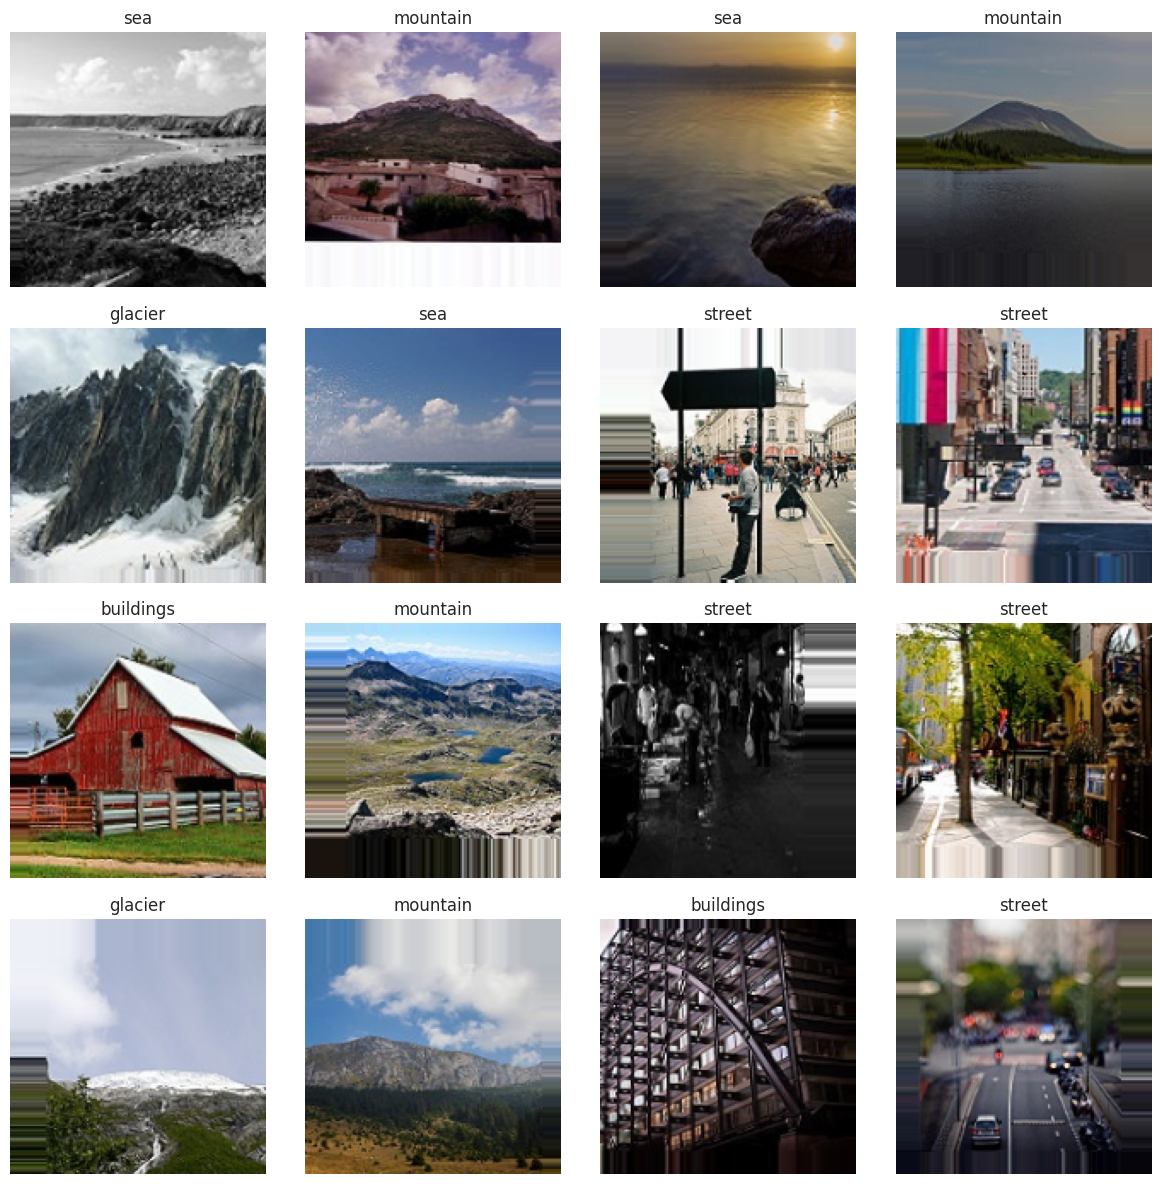

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

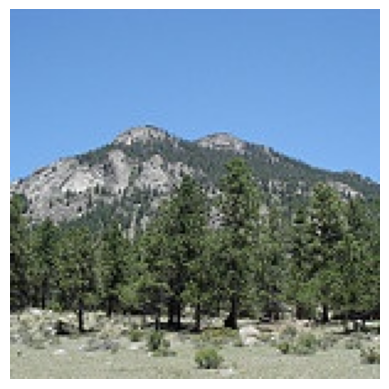

In [17]:
img = Image.open(train_path + "mountain/10028.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()


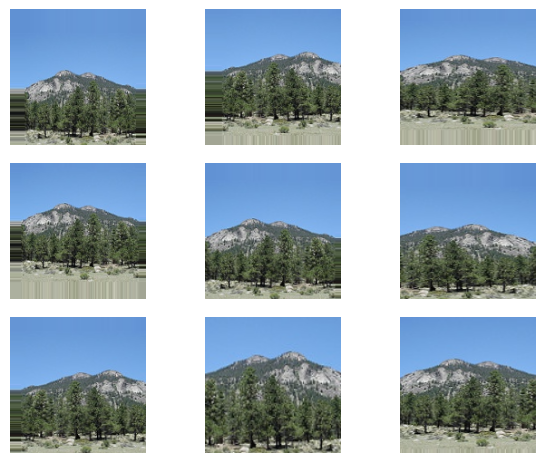

In [18]:
img_array = np.array(img)
img_array = img_array.reshape((1, 150, 150, 3))

for i, batch in enumerate (train_datagen.flow(img_array, batch_size = 1)):

    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0])
    plt.axis('off')

    if i == 8: break

# Show the plot
plt.tight_layout()
plt.show()

________

# Building The Model


now to build the CNN model by Keras , using Conv2D layers , MaxPooling & Denses

In [19]:
Model = keras.models.Sequential([
        Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        MaxPool2D(4,4),
        Conv2D(120,kernel_size=(3,3),activation='relu'),
        MaxPool2D(4,4),
        Flatten() ,
        Dense(120,activation='relu') ,
        Dropout(0.5) ,
        Dense(6,activation='softmax') ,
        ])

now to compile the model, using adam optimizer and categorical crossentropy loss

In [20]:
Model.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=1,
    mode="max",
    restore_best_weights=True)

In [22]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 200)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 120)       216120    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 120)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 120)               9

now to train the model , lets use 50 epochs now

In [23]:
epochs = 50
history = Model.fit(train_generator, validation_data = val_generator, epochs=epochs, batch_size=64, verbose=2, callbacks = [learning_rate_reduction, early_stopping],)

Epoch 1/50
88/88 - 149s - loss: 1.2551 - accuracy: 0.4961 - val_loss: 1.0804 - val_accuracy: 0.5777 - lr: 0.0010 - 149s/epoch - 2s/step
Epoch 2/50
88/88 - 114s - loss: 0.9893 - accuracy: 0.6268 - val_loss: 0.8512 - val_accuracy: 0.6887 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 3/50
88/88 - 114s - loss: 0.8846 - accuracy: 0.6688 - val_loss: 0.7714 - val_accuracy: 0.7118 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 4/50
88/88 - 117s - loss: 0.8197 - accuracy: 0.7028 - val_loss: 0.6930 - val_accuracy: 0.7511 - lr: 0.0010 - 117s/epoch - 1s/step
Epoch 5/50
88/88 - 135s - loss: 0.7887 - accuracy: 0.7137 - val_loss: 0.6857 - val_accuracy: 0.7564 - lr: 0.0010 - 135s/epoch - 2s/step
Epoch 6/50
88/88 - 116s - loss: 0.7270 - accuracy: 0.7397 - val_loss: 0.6972 - val_accuracy: 0.7475 - lr: 0.0010 - 116s/epoch - 1s/step
Epoch 7/50
88/88 - 114s - loss: 0.6896 - accuracy: 0.7514 - val_loss: 0.6904 - val_accuracy: 0.7536 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 8/50
88/88 - 114s - loss: 0.6860 - accurac

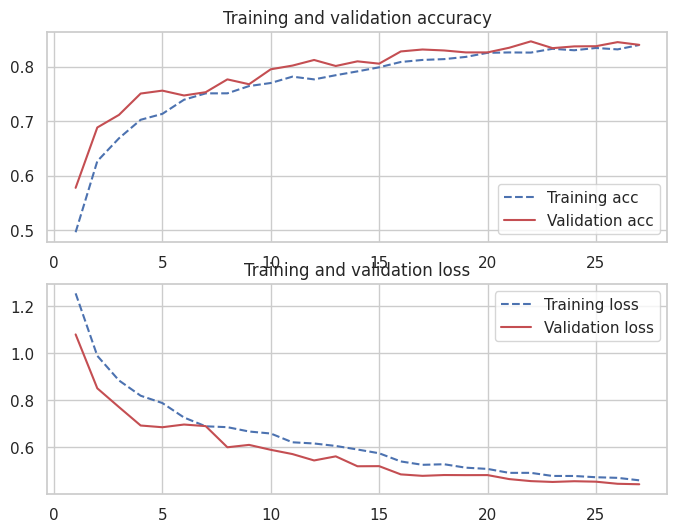

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize = (8, 6))

epochs = range(1, len(acc) + 1)
ax[0].plot(epochs, acc, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

how is the final loss & accuracy


In [25]:
ModelLoss, ModelAccuracy = Model.evaluate(test_generator)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

24/24 [==============================] - 9s 355ms/step - loss: 0.4065 - accuracy: 0.8603
Test Loss is 0.4065159559249878
Test Accuracy is 0.8603333234786987


ok, only 87% accuracy. we can be increase it by using pretrained models.


# VGG16 model

A convolutional neural network is also known as a ConvNet, which is a kind of artificial neural network. A ANN has an input layer, an output layer, and various hidden layers. VGG16 is a type of CNN (Convolutional Neural Network) that is considered to be one of the best computer vision models to date.

In [26]:
VGG16 = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))


58889256/58889256 [==============================] - 0s 0us/step


In [27]:
# Model DenseNet201

model_VGG16 = Sequential()
model_VGG16.add(VGG16)
model_VGG16.add(MaxPool2D())
model_VGG16.add(Dropout(0.5))
model_VGG16.add(BatchNormalization())
model_VGG16.add(Flatten())
model_VGG16.add(Dropout(0.2))
model_VGG16.add(Dense(256, activation="relu"))
model_VGG16.add(Dense(6, activation="softmax" , name="classification"))

In [28]:
# Menambahkan optimizer, loss, dan metrics
model_VGG16.compile(optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

# Ringkasan Model
model_VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 512)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 batch_normalization (Batch  (None, 2, 2, 512)         2048      
 Normalization)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)             

In [29]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=1,
    mode="max",
    restore_best_weights=True)

In [30]:
history = model_VGG16.fit(
                        train_generator,
                        steps_per_epoch = 11230// 128,
                        epochs = 5,
                        validation_data = val_generator,
                        validation_steps =  2804// 128,
                        callbacks=[learning_rate_reduction, early_stopping],
                        verbose=2
                        )

Epoch 1/5
87/87 - 207s - loss: 0.8687 - accuracy: 0.6598 - val_loss: 0.4929 - val_accuracy: 0.8259 - lr: 1.0000e-04 - 207s/epoch - 2s/step
Epoch 2/5
87/87 - 143s - loss: 0.4137 - accuracy: 0.8575 - val_loss: 0.3374 - val_accuracy: 0.8783 - lr: 1.0000e-04 - 143s/epoch - 2s/step
Epoch 3/5
87/87 - 144s - loss: 0.3319 - accuracy: 0.8870 - val_loss: 0.3516 - val_accuracy: 0.8854 - lr: 1.0000e-04 - 144s/epoch - 2s/step
Epoch 4/5
87/87 - 143s - loss: 0.3072 - accuracy: 0.8932 - val_loss: 0.3006 - val_accuracy: 0.8940 - lr: 1.0000e-04 - 143s/epoch - 2s/step
Epoch 5/5
87/87 - 159s - loss: 0.2749 - accuracy: 0.9052 - val_loss: 0.2929 - val_accuracy: 0.8947 - lr: 1.0000e-04 - 159s/epoch - 2s/step


In [31]:
ModelLoss, ModelAccuracy = model_VGG16.evaluate(test_generator)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

24/24 [==============================] - 13s 545ms/step - loss: 0.2812 - accuracy: 0.9053
Test Loss is 0.2812042534351349
Test Accuracy is 0.9053333401679993


### save model

In [32]:
model_VGG16.save("model_VGG16.h5", include_optimizer=True)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### results and test model

In [33]:
predictions = model_VGG16.predict(test_generator)


24/24 [==============================] - 9s 380ms/step


In [34]:
y_test = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
values = list(labels.values())

print(classification_report(y_test,y_pred, target_names = values))

              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       437
      forest       0.97      0.99      0.98       474
     glacier       0.81      0.90      0.85       553
    mountain       0.90      0.79      0.84       525
         sea       0.94      0.91      0.92       510
      street       0.93      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



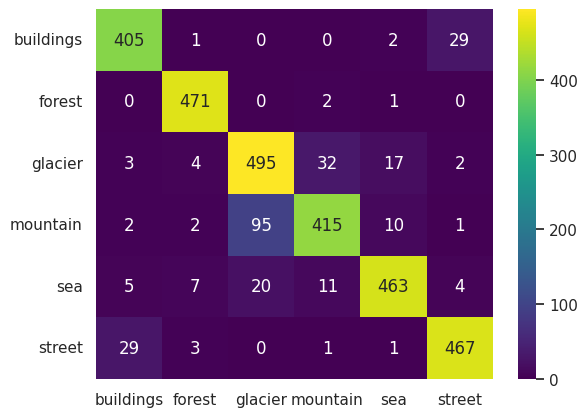

In [36]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test,y_pred),
            annot=True,
            fmt='.3g',
            xticklabels=values,
            yticklabels=values,
            cmap='viridis')
plt.show()

# Thanks